# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/AE/Sparse_AE/jetnet/'

Mounted at /content/drive


In [ ]:
from torch.utils.data import random_split, Dataset, DataLoader
import pandas as pd
import numpy as np
import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, mean_absolute_error
import torch.nn.utils.prune as prune
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau

# File Viewing

In [ ]:
def print_structure(file_name):
    with h5py.File(file_name, 'r') as f:
        f.visititems(print_item)

def print_item(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(name, obj.shape, obj.dtype)
    elif isinstance(obj, h5py.Group):
        print(name)

file_name = path + 't.hdf5'
print_structure(file_name)

jet_features (177945, 4) float32
particle_features (177945, 30, 4) float32


In [ ]:
with h5py.File(file_name, 'r') as f:
    jet_features_data = f['jet_features'][:]
    particle_features_data = f['particle_features'][:]

In [ ]:
def explore_hdf5(filename):
    with h5py.File(filename, 'r') as file:
        # Explore the file's datasets
        for name, dataset in file.items():
            print(f"Dataset name: {name}")
            print(f"Shape: {dataset.shape}")
            print(f"Datatype: {dataset.dtype}")
            print(f"Content (first 1 elements): {dataset[:2]}")
            print("------")

        # If you specifically want to see the labels (assuming they are in a dataset named 'labels'):
        if 'labels' in file:
            print(f"Labels: {file['labels'][:]}")

explore_hdf5(file_name)

Dataset name: jet_features
Shape: (177945, 4)
Datatype: float32
Content (first 1 elements): [[ 1.00083856e+03 -1.02152944e+00  1.73566376e+02  3.00000000e+01]
 [ 9.81978027e+02 -1.26148816e-02  1.09439171e+02  3.00000000e+01]]
------
Dataset name: particle_features
Shape: (177945, 30, 4)
Datatype: float32
Content (first 1 elements): [[[-1.53595209e-01  1.56128213e-01  9.74499434e-02  1.00000000e+00]
  [ 3.48459519e-02 -5.12997173e-02  5.63035794e-02  1.00000000e+00]
  [ 3.70894000e-02 -6.32425919e-02  5.48189804e-02  1.00000000e+00]
  [ 5.59603274e-02 -9.16898996e-02  5.38143031e-02  1.00000000e+00]
  [ 2.66186912e-02 -5.69021069e-02  5.33443168e-02  1.00000000e+00]
  [ 6.22004308e-02 -8.14543292e-02  4.65002544e-02  1.00000000e+00]
  [ 1.28914028e-01 -1.95329696e-01  3.87960188e-02  1.00000000e+00]
  [ 4.87124994e-02 -6.40405789e-02  3.82680222e-02  1.00000000e+00]
  [ 3.90293971e-02 -5.20421118e-02  3.79129350e-02  1.00000000e+00]
  [ 5.69136292e-02 -2.26166807e-02  3.51505280e-02  1

# Data Loading

In [ ]:
path = '/content/drive/MyDrive/AE/Sparse_AE/jetnet/'

def load_data_from_h5(filename):
    with h5py.File(filename, 'r') as f:
        #jet_features = f['jet_features'][:, :-1]  # rewrite to consider pt, eta, mass, number of particles accordingly
        particle_features = f['particle_features'][:, :, :-1]  # excluding the mask column
    #return jet_features, particle_features
    return particle_features

def select_top_particles(particle_data, n_particles=10):
    # Original pT values for the first few jets
    #print("Original pT values for the first jet:", particle_data[0, :, 2])

    sorted_indices = np.argsort(particle_data[:,:,2], axis=1)[:,::-1]
    batch_size = particle_data.shape[0]
    range_indices = np.arange(batch_size)[:,np.newaxis]
    top_particle_data = particle_data[range_indices, sorted_indices[:,:n_particles]]

    # Sorted pT values for the first few jets
    #print("Sorted pT values for the first jet:", top_particle_data[0, :, 2])

    return top_particle_data

def compute_mean_std(data):
    means = data.mean(axis=0)
    std_devs = data.std(axis=0)
    return means, std_devs

class ParticlePhysicsDataset(Dataset):
    def __init__(self, jet_features, particle_features, train=True, mean=None, std=None):
        # Reshape and concatenate data
        #jet_data = jet_features.reshape(-1, 3)  # as we have 3 features: pt, eta, mass
        particle_data = select_top_particles(particle_features).reshape(-1, 10*3)  # 10 top particles * 3 features each
        #concatenated_data = np.concatenate((particle_data, jet_data), axis=1)

        # Normalize
        if train:
            self.mean, self.std = compute_mean_std(particle_data)
        else:
            if mean is None or std is None:
                raise ValueError("For test set, mean and std must be provided.")
            self.mean, self.std = mean, std
        self.data = (particle_data - self.mean) / self.std
        self.data = torch.tensor(self.data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def load_data_by_filetype(filepaths):
    data_dict = {}
    for filepath in filepaths:
        filetype = filepath.split('/')[-1].split('.')[0]  # Extract the file type (g, q, t, w, z) from the filename
        data_dict[filetype] = load_data_from_h5(filepath)
    return data_dict

# Filepaths for each data type
background_files = [path + fname for fname in ['q.hdf5', 'g.hdf5']]
signal_files = [path + fname for fname in ['t.hdf5', 'w.hdf5', 'z.hdf5']]

# Load data by file type
background_data = load_data_by_filetype(background_files)
signal_data = load_data_by_filetype(signal_files)

q_particles = background_data['q']
g_particles = background_data['g']

# Function to split data into train, val, test using 50-10-40 split
def split_data(data):
    total_len = len(data)
    train_end = int(total_len * 0.5)
    val_end = train_end + int(total_len * 0.1)
    return data[:train_end], data[train_end:val_end], data[val_end:]

# Splitting data for q particles
train_q, val_q, test_q = split_data(q_particles)

# Splitting data for g particles
train_g, val_g, test_g = split_data(g_particles)

# Stacking the data
train_particle = np.vstack([train_q, train_g])
val_particle = np.vstack([val_q, val_g])
test_particle = np.vstack([test_q, test_g])

# Datasets for training, validation, and testing on background data
train_dataset = ParticlePhysicsDataset(None, train_particle)
val_dataset = ParticlePhysicsDataset(None, val_particle, train=False, mean=train_dataset.mean, std=train_dataset.std)
test_dataset = ParticlePhysicsDataset(None, test_particle, train=False, mean=train_dataset.mean, std=train_dataset.std)

# Datasets for each signal type
signal_datasets = {}
for key, particle in signal_data.items():
    signal_datasets[key] = ParticlePhysicsDataset(None, particle, train=False, mean=train_dataset.mean, std=train_dataset.std)


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=False)  # No need to shuffle validation data
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False)  # No need to shuffle test data
t_signal_dataloader = DataLoader(signal_datasets['t'], batch_size=1024, shuffle=False)
w_signal_dataloader = DataLoader(signal_datasets['w'], batch_size=1024, shuffle=False)
z_signal_dataloader = DataLoader(signal_datasets['z'], batch_size=1024, shuffle=False)

# Check Means

In [ ]:
def compute_dataloader_mean_std(dataloader):
    # Initialize values for running mean and variance
    running_sum = 0.0
    running_squared_sum = 0.0
    total_samples = 0

    for batch in dataloader:
        # Flatten the data batch as we only want feature-wise mean and std
        flat_batch = batch.view(batch.size(0), -1)

        running_sum += flat_batch.sum(dim=0)
        running_squared_sum += (flat_batch ** 2).sum(dim=0)
        total_samples += flat_batch.size(0)

    feature_means = running_sum / total_samples
    feature_variances = (running_squared_sum / total_samples) - (feature_means ** 2)
    feature_stds = torch.sqrt(feature_variances)

    # Compute overall mean and std
    mean = feature_means.mean().item()
    std = feature_stds.mean().item()
    return mean, std

dataloaders = {
    'train': train_dataloader,
    'validation': val_dataloader,
    'test': test_dataloader,
    't_signal': t_signal_dataloader,
    'w_signal': w_signal_dataloader,
    'z_signal': z_signal_dataloader
}

for name, dataloader in dataloaders.items():
    mean, std = compute_dataloader_mean_std(dataloader)
    print(f'{name} - Mean: {mean:.4f}, Std: {std:.4f}')

train - Mean: -0.0000, Std: 1.0000
validation - Mean: -0.0023, Std: 1.0034
test - Mean: -0.0008, Std: 1.0007
t_signal - Mean: -0.0071, Std: 1.6625
w_signal - Mean: 0.0571, Std: 1.0863
z_signal - Mean: 0.0507, Std: 1.1863


In [ ]:
def compute_dataloader_mean_std(dataloader):
    # Initialize values for running mean and variance
    running_sum = 0.0
    running_squared_sum = 0.0
    total_samples = 0

    for batch in dataloader:
        # Flatten the data batch as we only want feature-wise mean and std
        flat_batch = batch.view(batch.size(0), -1)

        running_sum += flat_batch.sum(dim=0)
        running_squared_sum += (flat_batch ** 2).sum(dim=0)
        total_samples += flat_batch.size(0)

    feature_means = running_sum / total_samples
    feature_variances = (running_squared_sum / total_samples) - (feature_means ** 2)
    feature_stds = torch.sqrt(feature_variances)

    return feature_means, feature_stds

dataloaders = {
    'train': train_dataloader,
    'test': test_dataloader,
    'validation': val_dataloader,
    't_signal': t_signal_dataloader,
    'w_signal': w_signal_dataloader,
    'z_signal': z_signal_dataloader
}

for name, dataloader in dataloaders.items():
    means, stds = compute_dataloader_mean_std(dataloader)
    print(f"{name} - Means: {means}, Stds: {stds}")

# Methods and Plotting

In [ ]:
# returns tpr value for specific threshold
# signal_losses is a tensor of individual losses for a given signal dataset
def get_tpr(threshold, signal_losses):
    tpr = torch.sum(signal_losses > threshold).float() / len(signal_losses)
    return tpr

# retruns threshold given an fpr
def get_threshold(fpr, background_losses):
    background_losses = background_losses.sort()[0] # Use PyTorch's sort function and pick values
    num_false_pos = int(len(background_losses) * fpr)
    threshold = background_losses[-num_false_pos]
    return threshold

#exponential linespace because we have a large threshold space to cover
def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power( np.linspace(start, stop, num=num), power)

def batch_MSE(input, output):
    loss = torch.mean(torch.pow(input - output, 2), dim = 1)
    return loss

def get_losses(model, dataloader):
    model.eval()
    criterion = batch_MSE
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = []
    with torch.no_grad():
        for data in dataloader:
            data = data.float().to(device)
            outputs = model(data)
            losses = criterion(data, outputs)
            results.append(losses)
    return torch.cat(results, 0)

def print_tprs(background_losses, signal_losses, fpr = 1e-5):
    threshold = get_threshold(fpr, background_losses)
    tpr = get_tpr(threshold, signal_losses)
    print(f"{tpr.item():.7f}")

def get_tpr_for_fpr(background_losses, signal_losses, fpr=1e-5):
    threshold = get_threshold(fpr, background_losses)
    tpr = get_tpr(threshold, signal_losses)
    return tpr.item()

# def plot_auc(background_losses, list_of_signal_losses, list_of_signal_labels, num_fprs=100):
#     fprs = powspace(9e-6, 1, 5, num_fprs)

#     #tpr_at_fpr_0_2 = {}  # Dictionary to store the TPR values for each signal at FPR=0.2

#     for signal_losses, signal_label in zip(list_of_signal_losses, list_of_signal_labels):
#         tprs = torch.zeros(num_fprs)
#         for fpr_idx, fpr in enumerate(fprs):
#             threshold = get_threshold(fpr, background_losses)
#             tpr = get_tpr(threshold, signal_losses)
#             tprs[fpr_idx] = tpr

#         # Store TPR for FPR=0.2 using the helper function
#         #tpr_at_fpr_0_2[signal_label] = get_tpr_for_fpr(background_losses, signal_losses, fpr=0.1)

#         # Plot curve for the current signal dataset
#         plt.plot(fprs, tprs.numpy(), label=f'{signal_label}, AUC: {auc(fprs, tprs.numpy()):.5f}')

#     #plt.semilogx()
#     #plt.semilogy()
#     plt.ylabel("True Positive Rate")
#     plt.xlabel("False Positive Rate")
#     plt.legend(loc='center right', fontsize='large')
#     plt.grid(True)
#     plt.tight_layout()
#     plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
#     #plt.axvline(0.1, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
#     plt.title(r"Particle ($\eta$, $\phi$, $p_T$) ROC")


#     # handles, labels = plt.gca().get_legend_handles_labels()
#     # new_labels = [f"{label}, TPR@FPR=0.2: {tpr_at_fpr_0_2[label.split(',')[0]]:.5f}" for label in labels]
#     # plt.legend(handles, new_labels, loc='center right')

#     plt.legend()
#     plt.show()

def plot_auc(background_losses, list_of_signal_losses, list_of_signal_labels, num_fprs=100):
    fprs = np.linspace(1e-4, 1, num_fprs)  # Regular spacing for the x-axis (TPR)

    for signal_losses, signal_label in zip(list_of_signal_losses, list_of_signal_labels):
        tprs = torch.zeros(num_fprs)
        for fpr_idx, fpr in enumerate(fprs):
            threshold = get_threshold(fpr, background_losses)
            tpr = get_tpr(threshold, signal_losses)
            tprs[fpr_idx] = tpr

        # Plot curve for the current signal dataset
        plt.plot(fprs, tprs.numpy(), label=f'{signal_label}, AUC: {auc(fprs, tprs.numpy()):.5f}')

    plt.yscale("log")  # Log scale for y-axis (FPR)
    plt.ylim(5e-4, 1.5)  # Set the range from 10^-3 to 1
    plt.ylabel("False Positive Rate")
    plt.xlabel("True Positive Rate")
    plt.legend(loc='center right', fontsize='large')
    plt.grid(True)
    plt.tight_layout()
    plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
    plt.title(r"Particle ($\eta$, $\phi$, $p_T$) ROC")
    plt.legend()
    plt.show()

def plot_histogram(background_losses, list_of_signal_losses, list_of_signal_labels, bin_size):
    # Make sure the number of signal loss tensors matches the number of labels
    assert len(list_of_signal_losses) == len(list_of_signal_labels), "Mismatch between number of signals and labels"

    # Calculate the total number of events
    total_events = background_losses.size(0) + sum([loss.size(0) for loss in list_of_signal_losses])

    plt.figure(figsize=(10,8))

    # Weights for the background
    background_weights = np.ones_like(background_losses.cpu().numpy()) * background_losses.size(0) / total_events

    plt.hist(background_losses.cpu().numpy(), bins=bin_size, density=True, histtype='step', fill=False, linewidth=1.5, label='Background', weights=background_weights)

    # Now, iterate through each signal and plot it
    for signal_losses, label in zip(list_of_signal_losses, list_of_signal_labels):
        signal_weights = np.ones_like(signal_losses.cpu().numpy()) * signal_losses.size(0) / total_events
        plt.hist(signal_losses.cpu().numpy(), bins=bin_size, density=True, histtype='step', fill=False, linewidth=1.5, label=label, weights=signal_weights)

    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel("Autoencoder Loss")
    plt.ylabel("Probability Density")
    plt.title('Particle ($\eta$, $\phi$, $p_T$) MSE loss')

    # Added grid and increased legend size
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize='large')

    plt.show()

def get_latent_representations(dataloader, model):
    device = next(model.parameters()).device  # get the device of the model
    latent_representations = []

    for batch_data in dataloader:
        batch_data = batch_data.to(device)  # move data to the same device as the model
        with torch.no_grad():
            latent = model.encoder(batch_data).cpu().numpy()  # forward pass and then move to CPU for numpy conversion
            latent_representations.append(latent)

    return np.concatenate(latent_representations, axis=0)

# Pruning Methods

In [ ]:
# def get_parameters_to_prune(model):
#     parameters_to_prune = []
#     for name, module in model.named_modules():
#         if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
#             parameters_to_prune.append((module, 'weight'))
#     return tuple(parameters_to_prune)

def get_parameters_to_prune(model):
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))
            parameters_to_prune.append((module, 'bias'))
        elif isinstance(module, torch.nn.BatchNorm1d) or isinstance(module, torch.nn.BatchNorm2d):
            parameters_to_prune.append((module, 'weight'))
    return tuple(parameters_to_prune)

def sparsity_print(model):
    prune.global_unstructured(get_parameters_to_prune(model),pruning_method=prune.L1Unstructured,amount=0)
    zero = total = 0
    for module, _ in get_parameters_to_prune(model):
        zero += float(torch.sum(module.weight == 0))
        total += float(module.weight.nelement())
    print('Number of Zero Weights:', zero)
    print('Total Number of Weights:', total)
    print('Sparsity', zero/total)
    return zero, total

# def layerwise_sparsity_print(model):
#     parameters_to_prune = get_parameters_to_prune(model)

#     for idx, (module, _) in enumerate(parameters_to_prune):
#         zero = float(torch.sum(module.weight == 0))
#         total = float(module.weight.nelement())

#         print(type(module))

#         print(f'Layer {idx + 1} Sparsity: {zero / total:.2%}')
#         print(f'Layer {idx + 1} Number of Zero Weights:', zero)
#         print(f'Layer {idx + 1} Total Number of Weights:', total)
#         print("-----------------------------")

#     total_zero = sum([float(torch.sum(module.weight == 0)) for module, _ in parameters_to_prune])
#     total_weights = sum([float(module.weight.nelement()) for module, _ in parameters_to_prune])

#     print('Overall Number of Zero Weights:', total_zero)
#     print('Overall Total Number of Weights:', total_weights)
#     print('Overall Sparsity:', total_zero / total_weights)

#     return total_zero, total_weights

def layerwise_sparsity_print(model):
    parameters_to_prune = get_parameters_to_prune(model)
    total_zero = 0
    total_weights = 0
    for idx, (module, name) in enumerate(parameters_to_prune):
        if name == 'weight':
          zero = float(torch.sum(module.weight == 0))
          total = float(module.weight.nelement())
        elif name == 'bias':
          zero = float(torch.sum(module.bias == 0))
          total = float(module.bias.nelement())
        total_zero += zero
        total_weights += total
        print(f'Layer {idx + 1} Type: {type(module)} Name: {name}')
        print(f'Layer {idx + 1} Sparsity: {zero / total:.2%}')
        print(f'Layer {idx + 1} Number of Zero Weights:', zero)
        print(f'Layer {idx + 1} Total Number of Weights:', total)
        print("-----------------------------")
    print('Overall Number of Zero Weights:', total_zero)
    print('Overall Total Number of Weights:', total_weights)
    print('Overall Sparsity:', total_zero / total_weights)
    return total_zero, total_weights

def Prune(model, train_loader, val_loader, pruning_iters = 30, num_epochs = 60, amount = .2, delay_pruning_epochs = 0):
    zeros = [] #keeps track of zeros at each iteration
    tprs = [] #keeps track of tpr at each pruning iteration
    train_losses = [] #keeps track of training loss at each pruning iteration
    val_losses = [] #keeps track of validation loss at each pruning iteration
    background_losses_all = [] #keeps track of background losses at each pruning iteration
    signal_losses_all = []
    t_losses = []  # keeps track of t losses at each pruning iteration
    w_losses = []  # keeps track of w losses at each pruning iteration
    z_losses = []  # keeps track of z losses at each pruning iteration]

    #models_list = [] #create a list of models for each iteration

    fpr_target = 0.1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Create rewind point for model
    model_rewind = copy.deepcopy(model).to(device)

    #Pretrain model before pruning
    train_loss, val_loss = train(model, train_loader, num_epochs = num_epochs, get_losses = True, val_loader = val_loader)

    # Compute background and signal losses after training
    background_losses = get_losses(model, test_dataloader)
    t = get_losses(model, t_signal_dataloader)
    w = get_losses(model, w_signal_dataloader)
    z = get_losses(model, z_signal_dataloader)

    background_losses_all.append(background_losses)
    signal_losses_all.append([t, w, z])

    #Lottery Ticket Rewinding: Prune, Rewind, Train
    for i in range(pruning_iters):
        # model_rewind_state_dict = model.state_dict()
        # model_rewind = Autoencoder().to(device) # Or replace `Autoencoder()` with whatever your model's class name is
        # model_rewind.load_state_dict(model_rewind_state_dict)
        print('Pruning Iteration:', i+1)
        #Prune
        prune.global_unstructured(get_parameters_to_prune(model),pruning_method=prune.L1Unstructured,amount=amount)

        #prune.global_unstructured(get_parameters_to_prune(model), pruning_method=prune.LnStructured, amount=amount, n=1)

        #Rewind Weights
        for idx, (module, _) in enumerate(get_parameters_to_prune(model)):
            with torch.no_grad():
                module_rewind = get_parameters_to_prune(model_rewind)[idx][0]
                module.weight_orig.copy_(module_rewind.weight.to(device)) # Ensure that module_rewind.weight is on the correct device
        #Train Weights
        train_loss, val_loss = train(model, train_loader, num_epochs = num_epochs, get_losses = True, val_loader = val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Compute background and signal losses after training
        background_losses = get_losses(model, test_dataloader)
        t = get_losses(model, t_signal_dataloader)
        w = get_losses(model, w_signal_dataloader)
        z = get_losses(model, z_signal_dataloader)

        background_losses_all.append(background_losses)
        signal_losses_all.append([t, w, z])

        #Log Results
        zero, total = sparsity_print(model)
        zeros.append(zero)

        # Compute TPR for specific FPR
        tpr_iter = []  # keeps track of tpr for each signal dataset in this iteration

        # Calculate the threshold based on the target FPR and background losses
        background_losses_sorted = torch.sort(background_losses_all[-1])[0]
        num_false_pos = int(len(background_losses_sorted) * fpr_target)
        threshold = background_losses_sorted[-num_false_pos]

        for j in range(3):
            tpr = get_tpr(threshold, signal_losses_all[-1][j])
            tpr_iter.append(tpr)
            # print(f'Pruning Iteration {i+1}, Signal Dataset {j+1}: TPR at FPR {fpr_target}: {tpr}')

        tprs.append(tpr_iter)

        # Print layerwise sparsity after each iteration
        layerwise_sparsity_print(model)

    return train_losses, val_losses, zeros, total, tprs, background_losses_all, signal_losses_all

# Pruning Plots

In [ ]:
def plot_and_return_losses_vs_sparsity(zeros, total, train_losses, val_losses, plot=False):
    # Convert zeros to sparsity (divide by total)
    sparsity = [zero / total for zero in zeros]

    # Create lists to return
    train_losses_last = [losses[-1] for losses in train_losses]
    val_losses_last = [losses[-1] for losses in val_losses]

    if plot:
        plt.figure(figsize=(10, 5))
        plt.title("Training and Validation Loss vs. Sparsity")
        plt.plot(sparsity, train_losses_last, label="train")
        plt.plot(sparsity, val_losses_last, label="val")
        plt.xlabel("Sparsity")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    return sparsity, train_losses_last, val_losses_last

def plot_and_return_tprs(tprs, plot=False):

    print("Length of tprs[0]:", len(tprs[0]))
    print("First entry of tprs:", tprs[0])

    # Number of signal datasets
    num_datasets = len(tprs[0])

    print(tprs[0])

    # Add correct signal labels
    signal_labels = ['Top Quark','W Boson','Z Boson']

    if num_datasets > len(signal_labels):
        print("Error: More datasets than labels provided.")
        return

    tprs_all_datasets = []
    # For each signal dataset
    for i in range(num_datasets):
        # Extract the TPR for each pruning iteration for the current signal dataset
        tprs_dataset = [tprs_iter[i].cpu().numpy() for tprs_iter in tprs]
        tprs_all_datasets.append(tprs_dataset)
        if plot:
            plt.plot(tprs_dataset, label=signal_labels[i])

    if plot:
        # Set the labels for the x and y axes
        #plt.semilogy()
        plt.xlabel('Pruning Iteration')
        plt.ylabel('TPR')

        # Set the title for the plot
        plt.title('TPR at each Pruning Iteration')

        # Add a legend
        plt.legend()

        # Show the plot
        plt.show()

    return tprs_all_datasets

def calc_and_plot_losses(background_losses, signal_losses, signal_labels, num_thresholds=100, plot=False):
  fpr_losses_all = []
  tpr_losses_all = []
  for pruning_iter in range(len(background_losses)): #number of pruning iters
      fpr_losses = []
      tpr_losses = np.zeros((3, num_thresholds))

      # For each possible threshold, calculate the tpr/fpr loss
      for idx, threshold in enumerate(powspace(0,500000, 10, num_thresholds)): #fix later to smaller increments
          # Calculate fpr from the background data
          num_false_pos = torch.sum(background_losses[pruning_iter] > threshold).cpu().item()

          fpr_loss = num_false_pos / len(background_losses[pruning_iter]) # fpr = fp/(fp+tn)
          fpr_losses.append(fpr_loss)

          # Calculate tpr for each signal dataset
          for i in range(3):
              losses = signal_losses[pruning_iter][i]
              num_true_pos = torch.sum(losses > threshold).cpu().item() # counts number of individual losses above threshold
              tpr_loss = num_true_pos / len(losses)
              tpr_losses[i,idx] = tpr_loss

      if plot:
          # Plot curves for each signal dataset
          for i in range(3):
              plt.plot(fpr_losses, tpr_losses[i], label = signal_labels[i] + ', auc: {}'.format(( round(auc(fpr_losses,tpr_losses[i]),5) )))
          #plt.semilogx()
          #plt.semilogy()
          plt.ylabel("True Positive Rate")
          plt.xlabel("False Positive Rate")
          plt.legend(loc='center right')
          plt.grid(True)
          plt.tight_layout()
          plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
          #plt.axvline(0.1, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
          plt.title('ROC AE Pruning Iteration {}'.format(pruning_iter))
          plt.show()

      fpr_losses_all.append(fpr_losses)
      tpr_losses_all.append(tpr_losses)

  return fpr_losses_all, tpr_losses_all

def prune_plot_histogram(background_losses_all, signal_losses_all, signal_labels, bin_size=100, plot=False):
    for iteration in range(len(background_losses_all)):
        # Get losses for this iteration
        background_losses = background_losses_all[iteration]
        signal_losses = signal_losses_all[iteration]

        # Preparing data and labels for the plot
        losses = [background_losses.cpu().numpy()] + [loss.cpu().numpy() for loss in signal_losses]
        labels = ['background'] + [signal_labels[i] for i in range(3)]

        plt.figure(figsize=(10,8))
        for i in range(4):
            plt.hist(losses[i], bins=bin_size, density=True, histtype='step', fill=False, linewidth=1.5, label = labels[i])

        #plt.yscale('log')
        #plt.xscale('log')
        plt.xlabel("Autoencoder Loss")
        plt.ylabel("Probability (a.u.)")
        plt.title('MSE loss Pruning Iteration {}'.format(iteration))
        plt.legend()  # Show legend to distinguish different histograms
        plt.show()

    return losses, labels

def plot_AUCs_for_pruning_iters(background_losses, signal_losses, signal_labels, num_thresholds=100):
    # To store AUC values for each pruning iteration and each signal
    auc_values = np.zeros((len(background_losses), 3))

    for pruning_iter in range(len(background_losses)):
        fpr_losses = []
        tpr_losses = np.zeros((3, num_thresholds))

        for idx, threshold in enumerate(powspace(0,500000, 10, num_thresholds)):
            num_false_pos = torch.sum(background_losses[pruning_iter] > threshold).cpu().item()
            fpr_loss = num_false_pos / len(background_losses[pruning_iter])
            fpr_losses.append(fpr_loss)

            for i in range(3):
                losses = signal_losses[pruning_iter][i]
                num_true_pos = torch.sum(losses > threshold).cpu().item()
                tpr_loss = num_true_pos / len(losses)
                tpr_losses[i, idx] = tpr_loss

        # Calculate AUC for each signal and store
        for i in range(3):
            auc_values[pruning_iter, i] = auc(fpr_losses, tpr_losses[i])

    # Plot AUCs for each pruning iteration
    for i in range(3):
        plt.plot(range(len(background_losses)), auc_values[:, i], label=signal_labels[i], marker='o')

    plt.xlabel('Pruning Iteration')
    plt.ylabel('AUC')
    plt.title('AUC for Each Pruning Iteration')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def get_best_average_AUC_iteration(background_losses, signal_losses, signal_labels, num_thresholds=100):
    # Assuming there are 3 signals, so the shape of auc_values is (num_iterations, 3)
    auc_values = np.zeros((len(background_losses), 3))

    # Calculate AUC for each pruning iteration and signal
    for pruning_iter in range(len(background_losses)):
        fpr_losses = []
        tpr_losses = np.zeros((3, num_thresholds))

        for idx, threshold in enumerate(powspace(0, 500000, 10, num_thresholds)):
            num_false_pos = torch.sum(background_losses[pruning_iter] > threshold).cpu().item()
            fpr_loss = num_false_pos / len(background_losses[pruning_iter])
            fpr_losses.append(fpr_loss)

            for i in range(3):
                losses = signal_losses[pruning_iter][i]
                num_true_pos = torch.sum(losses > threshold).cpu().item()
                tpr_loss = num_true_pos / len(losses)
                tpr_losses[i, idx] = tpr_loss

        # Calculate AUC for each signal and store
        for i in range(3):
            auc_values[pruning_iter, i] = auc(fpr_losses, tpr_losses[i])

    # Find pruning iteration with the highest average AUC
    average_aucs = np.mean(auc_values, axis=1)  # Average AUC for each pruning iteration
    best_iter = np.argmax(average_aucs)

    # Print AUCs for the best iteration
    print(f"Best Pruning Iteration: {best_iter}")
    for i in range(3):
        print(f"AUC for {signal_labels[i]}: {auc_values[best_iter, i]}")

    return best_iter

# Model

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_size = 30, latent_dim=4, dropout_rate=0):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.BatchNorm1d(input_size),
            self._init_weights(nn.Linear(input_size, 16)),
            nn.LeakyReLU(0.3),
            nn.Dropout(dropout_rate),
            self._init_weights(nn.Linear(16, 8)),
            nn.LeakyReLU(0.3),
            nn.Dropout(dropout_rate),
            # self._init_weights(nn.Linear(32, 16)),
            # nn.LeakyReLU(0.3),
            # nn.Dropout(dropout_rate),
            self._init_weights(nn.Linear(8, latent_dim)),
        )
        # Decoder
        self.decoder = nn.Sequential(
            self._init_weights(nn.Linear(latent_dim, 8)),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.3),
            self._init_weights(nn.Linear(8, 16)),
            nn.LeakyReLU(0.3),
            # self._init_weights(nn.Linear(32, 64)),
            # nn.LeakyReLU(0.3),
            self._init_weights(nn.Linear(16, input_size))
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def _init_weights(self, layer): # implemented this to mimic the HeUniform in tf model
        nn.init.kaiming_uniform_(layer.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)
        return layer

def train(model, train_loader, num_epochs, lr = 0.001, early_stopping_patience=10, get_losses = False, val_loader = None):
    # Init training optimizers
    optimizer = optim.Adam(model.parameters(), lr = lr)
    #optimizer = optim.Adagrad(model.parameters(), lr=lr)
    #scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=2, verbose=True, min_lr=1E-6)
    criterion = nn.MSELoss()
    #criterion = mae_loss

    best_model_state = None  # Save the best model's state dict here

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    device = next(model.parameters()).device # added for cuda

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            data = data.to(device)  # ensure data is on the same device as the model (added for cuda)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(data, outputs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print('epoch [{}/{}], Training loss:{:.4f}'.format(epoch + 1, num_epochs, train_loss / len(train_loader)))
        if get_losses == True:
            val_loss = test(model, val_loader)
            train_losses.append(train_loss / len(train_loader))
            val_losses.append(val_loss)

            # Call the scheduler step with the current validation loss
            scheduler.step(val_loss)

            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = copy.deepcopy(model.state_dict())  # Update best model state
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered after {} epochs".format(epoch + 1))
                model.load_state_dict(best_model_state)  # Revert to best model state
                break

    if get_losses == True:
        return train_losses, val_losses

def test(model, dataloader):
  # Testing the autoencoder
  model.eval()
  criterion = nn.MSELoss()
  #criterion = mae_loss
  test_loss = 0
  with torch.no_grad():
      for data in dataloader:
          data = data.to(device)  # Move data to the device that the model is on
          outputs = model(data)
          loss = criterion(data, outputs)
          test_loss += loss.item()

  test_loss = test_loss / len(dataloader)

  print('Loss: {:.4f}'.format(test_loss))
  return test_loss

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Run Training

In [ ]:
# Run training script
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
train_losses, val_losses = train(model, train_dataloader, num_epochs = 50, lr = .001, get_losses = True, val_loader = val_dataloader)

epoch [1/50], Training loss:1.2457
Loss: 0.8828
epoch [2/50], Training loss:0.8131
Loss: 0.7747
epoch [3/50], Training loss:0.7436
Loss: 0.7270
epoch [4/50], Training loss:0.7084
Loss: 0.7003
epoch [5/50], Training loss:0.6880
Loss: 0.6835
epoch [6/50], Training loss:0.6740
Loss: 0.6711
epoch [7/50], Training loss:0.6632
Loss: 0.6613
epoch [8/50], Training loss:0.6543
Loss: 0.6530
epoch [9/50], Training loss:0.6463
Loss: 0.6455
epoch [10/50], Training loss:0.6393
Loss: 0.6392
epoch [11/50], Training loss:0.6336
Loss: 0.6341
epoch [12/50], Training loss:0.6294
Loss: 0.6303
epoch [13/50], Training loss:0.6260
Loss: 0.6273
epoch [14/50], Training loss:0.6233
Loss: 0.6247
epoch [15/50], Training loss:0.6208
Loss: 0.6225
epoch [16/50], Training loss:0.6187
Loss: 0.6210
epoch [17/50], Training loss:0.6168
Loss: 0.6186
epoch [18/50], Training loss:0.6151
Loss: 0.6171
epoch [19/50], Training loss:0.6137
Loss: 0.6156
epoch [20/50], Training loss:0.6124
Loss: 0.6146
epoch [21/50], Training loss:

In [ ]:
print(f"Total number of trainable parameters: {count_parameters(model)}")

Total number of trainable parameters: 1362


In [ ]:
background_losses = get_losses(model, test_dataloader)
t_losses = get_losses(model, t_signal_dataloader)
w_losses = get_losses(model, w_signal_dataloader)
z_losses = get_losses(model, z_signal_dataloader)

#combined_signal_losses = torch.cat([t_losses, w_losses, z_losses])

print_tprs(background_losses, t_losses, fpr = 0.1)
print_tprs(background_losses, w_losses, fpr = 0.1)
print_tprs(background_losses, z_losses, fpr = 0.1)

0.6824749
0.0240557
0.0722286


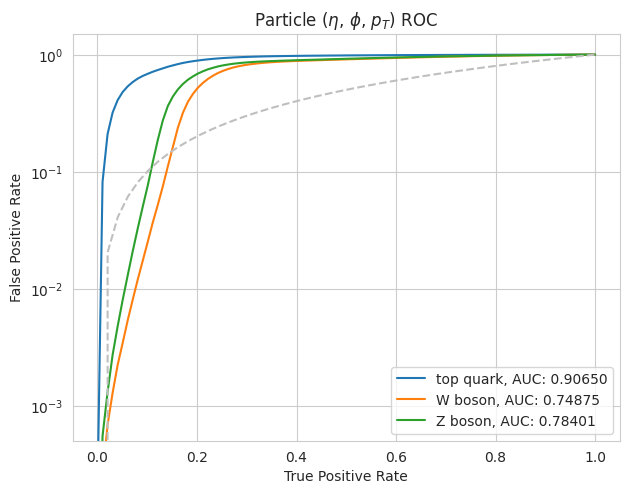

In [ ]:
plot_auc(background_losses, [t_losses, w_losses, z_losses], ['top quark', 'W boson', 'Z boson'])

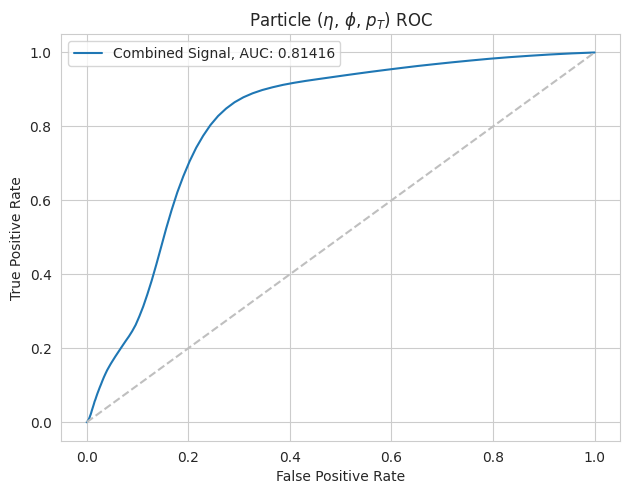

In [ ]:
# 1. Concatenate the signal losses
combined_signal_losses = torch.cat([t_losses, w_losses, z_losses])

# Now you can call your plot_auc function for the combined signal
plot_auc(background_losses, [combined_signal_losses], ['Combined Signal'])

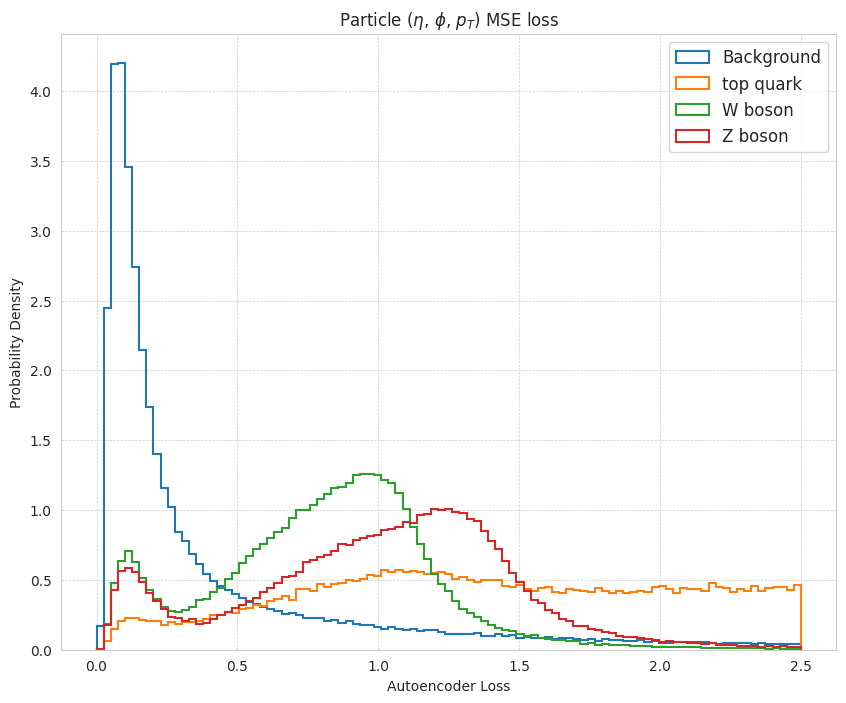

In [ ]:
plot_histogram(background_losses, [t_losses, w_losses, z_losses], ['top quark', 'W boson', 'Z boson'], bin_size = np.linspace(0, 2.5, 100))

In [ ]:
background_latent = get_latent_representations(test_dataloader, model)
t_latent = get_latent_representations(t_signal_dataloader, model)
w_latent = get_latent_representations(w_signal_dataloader, model)
z_latent = get_latent_representations(z_signal_dataloader, model)

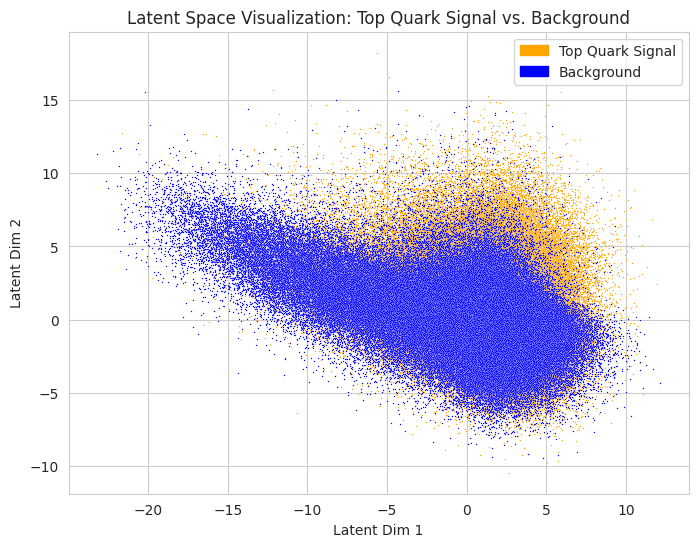

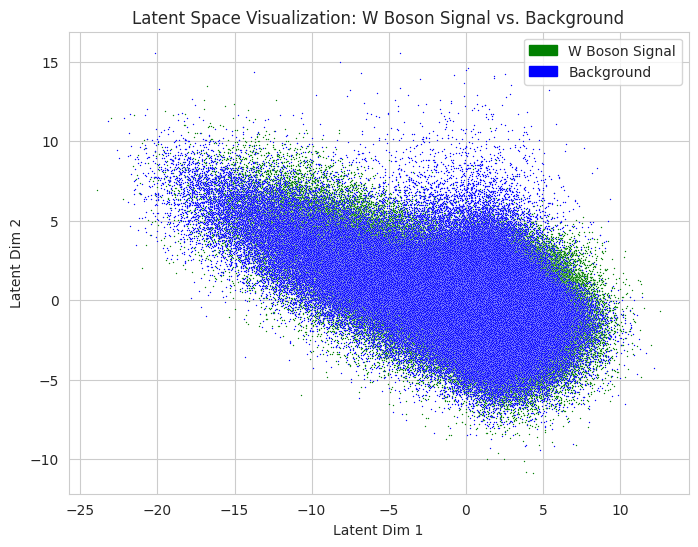

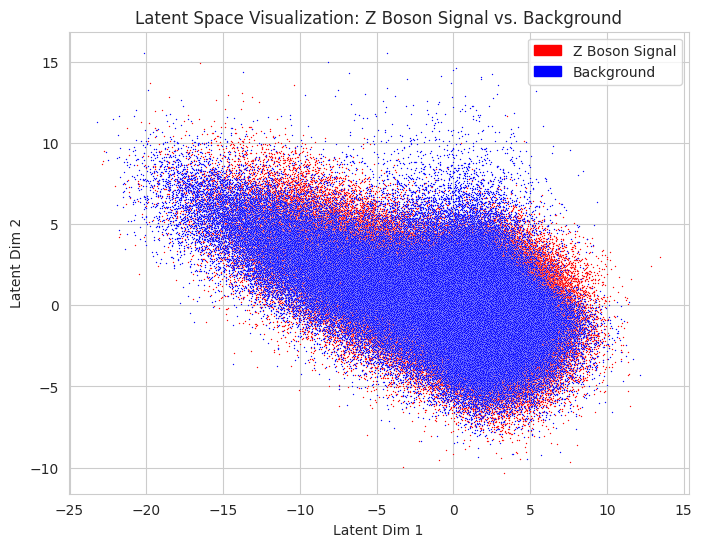

In [ ]:
import seaborn as sns
import matplotlib.patches as mpatches

# Set a style
sns.set_style("whitegrid")

# Function to plot background vs. one type of signal
def plot_background_vs_signal(background_latent, signal_latent, signal_label, signal_color):
    plt.figure(figsize=(8, 6))

    # Plot background latent space without legend
    #sns.scatterplot(x=background_latent[:, 0], y=background_latent[:, 1], color='blue', alpha=1, s=1)

    # Plot signal latent space without legend
    sns.scatterplot(x=signal_latent[:, 0], y=signal_latent[:, 1], color=signal_color, alpha=1, s=1)

    # Plot background latent space without legend
    sns.scatterplot(x=background_latent[:, 0], y=background_latent[:, 1], color='blue', alpha=1, s=1)

    # Manually define legend handles
    signal_patch = mpatches.Patch(color=signal_color, label=signal_label)
    background_patch = mpatches.Patch(color='blue', label='Background')

    #plt.yscale('log')
    #plt.xscale('log')

    plt.legend(handles=[signal_patch, background_patch], loc='upper right')
    plt.xlabel('Latent Dim 1')
    plt.ylabel('Latent Dim 2')
    plt.title(f"Latent Space Visualization: {signal_label} vs. Background")
    plt.show()

# Create individual plots for each signal
plot_background_vs_signal(background_latent, t_latent, 'Top Quark Signal', 'orange')
plot_background_vs_signal(background_latent, w_latent, 'W Boson Signal', 'green')
plot_background_vs_signal(background_latent, z_latent, 'Z Boson Signal', 'red')

# Visualize the loss landscape

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_loss_landscape(model, criterion, dataloader, step=0.2, range_=0.5):
    model_device = next(model.parameters()).device

    # Get the current state_dict
    original_state_dict = model.state_dict()

    # Filter out Long tensors
    filtered_state_dict = {k: v for k, v in original_state_dict.items() if v.dtype != torch.long}

    # Create direction vectors based on the filtered state dict
    d1 = {k: torch.randn_like(v) for k, v in filtered_state_dict.items()}
    d2 = {k: torch.randn_like(v) for k, v in filtered_state_dict.items()}

    x = np.arange(-range_, range_ + step, step)
    y = np.arange(-range_, range_ + step, step)
    Z = np.zeros((len(x), len(y)))

    # Compute loss for each perturbation
    for i, x_ in enumerate(x):
        for j, y_ in enumerate(y):
            perturbed_state_dict = {k: (original_v + x_ * d1.get(k, torch.tensor(0).to(model_device)) +
                                    y_ * d2.get(k, torch.tensor(0).to(model_device))).to(model_device)
                                    for k, original_v in original_state_dict.items()}

            model.load_state_dict(perturbed_state_dict)

            loss_sum = 0.0
            num_samples = 0
            for inputs in dataloader:
                inputs = inputs.to(model_device)  # This line moves the inputs to the same device as the model
                outputs = model(inputs)
                per_sample_losses = criterion(outputs, inputs)  # Tensor of per-sample losses
                loss_sum += per_sample_losses.sum().item()  # Sum the per-sample losses
                num_samples += per_sample_losses.size(0)

            Z[i, j] = loss_sum / num_samples  # Average loss across all samples

    model.load_state_dict(original_state_dict)

    Z = np.clip(Z, a_min=0.0001, a_max=10)

    plt.contourf(x, y, Z, levels=np.linspace(Z.min(), Z.max(), 20), cmap='RdGy')
    plt.colorbar()
    plt.show()

# Call the function using your model, criterion (loss function), and a validation dataloader.

/usr/local/lib/python3.10/dist-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/usr/local/lib/python3.10/dist-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


ValueError: ignored

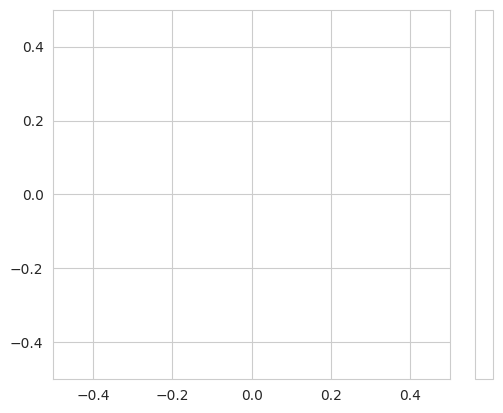

In [ ]:
visualize_loss_landscape(model, batch_MSE, t_signal_dataloader)

# Run Pruning

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
train_losses, val_losses, zeros, total, tprs, background_losses_all, signal_losses_all = Prune(model, train_dataloader, val_dataloader, pruning_iters = 10, num_epochs = 10, amount = .2, delay_pruning_epochs=0)

NameError: ignored

In [ ]:
get_parameters_to_prune(model)

In [ ]:
list(model.named_modules())

In [ ]:
layerwise_sparsity_print(model)

In [ ]:
signal_labels = ['Top Quark', 'W Boson', 'Z Boson']

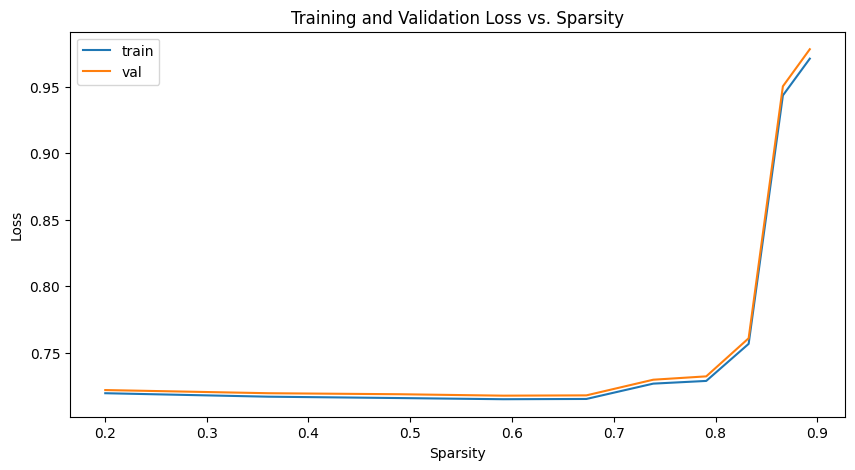

In [ ]:
# Plot and return sparsity vs losses
sparsity, train_losses_last, val_losses_last = plot_and_return_losses_vs_sparsity(zeros, total, train_losses, val_losses, plot=True)

Length of tprs[0]: 3
First entry of tprs: [tensor(0.8855, device='cuda:0'), tensor(0.4344, device='cuda:0'), tensor(0.6964, device='cuda:0')]
[tensor(0.8855, device='cuda:0'), tensor(0.4344, device='cuda:0'), tensor(0.6964, device='cuda:0')]


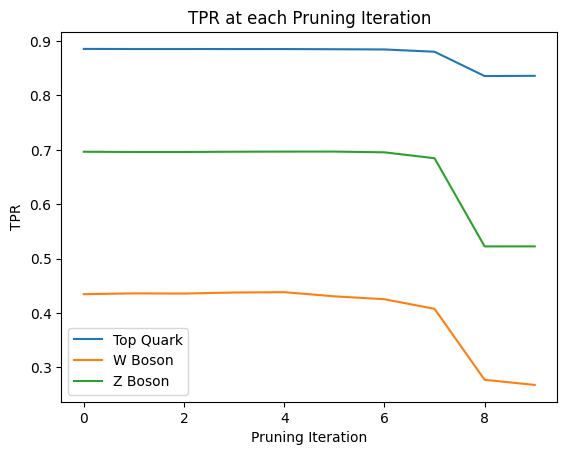

In [ ]:
# Plot and return TPRs
# for an FPR of 0.2 - to change need to alter in the Prune method
tprs_all_datasets = plot_and_return_tprs(tprs, plot=True)

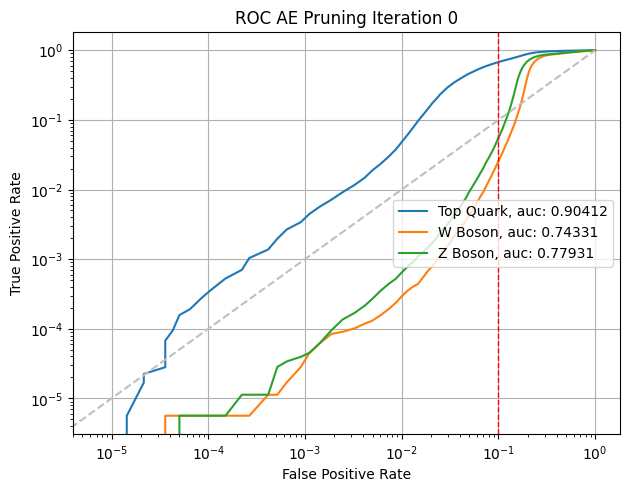

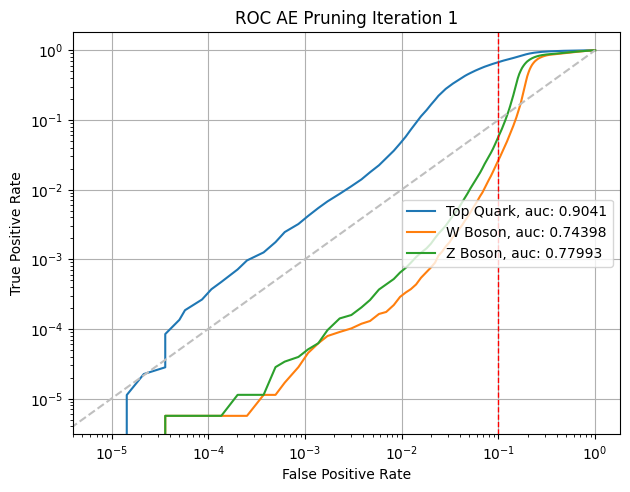

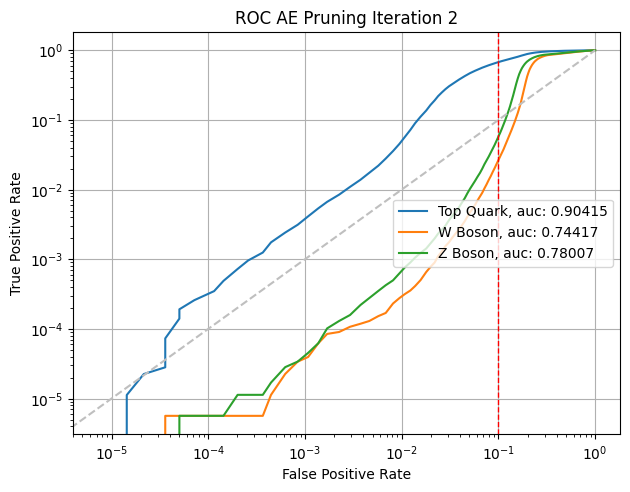

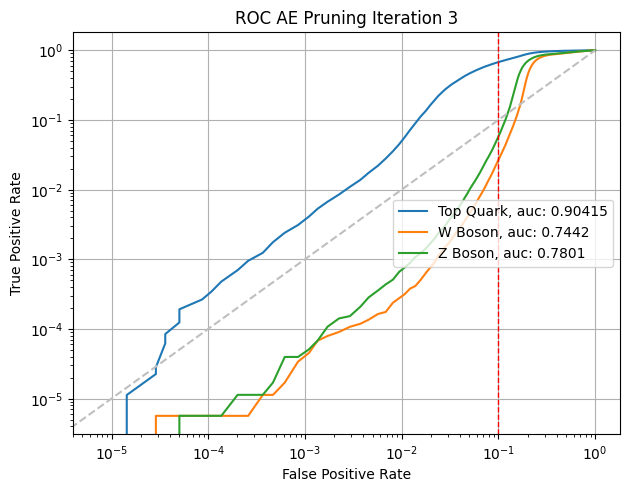

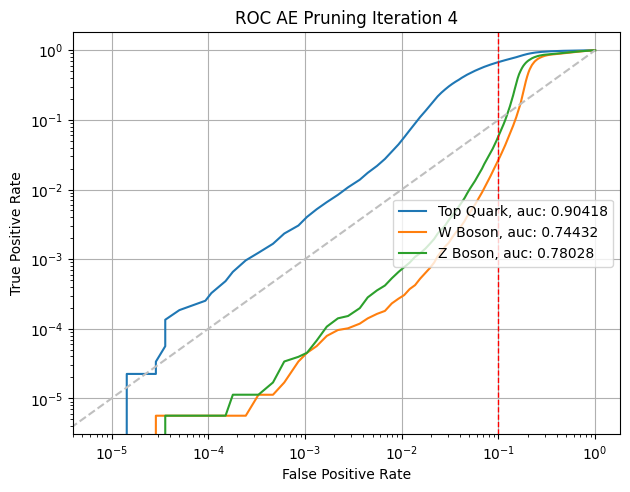

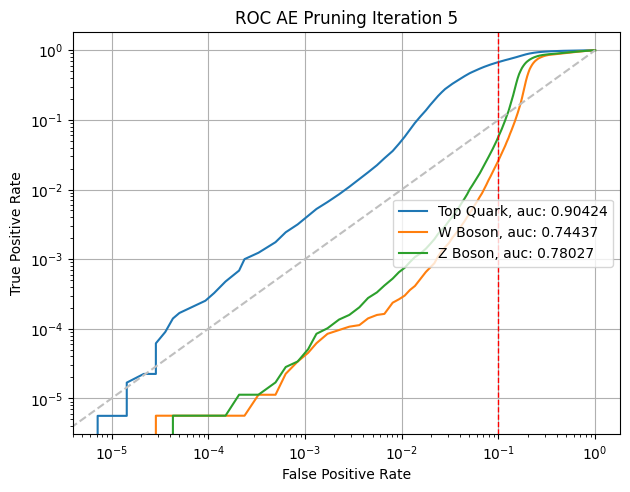

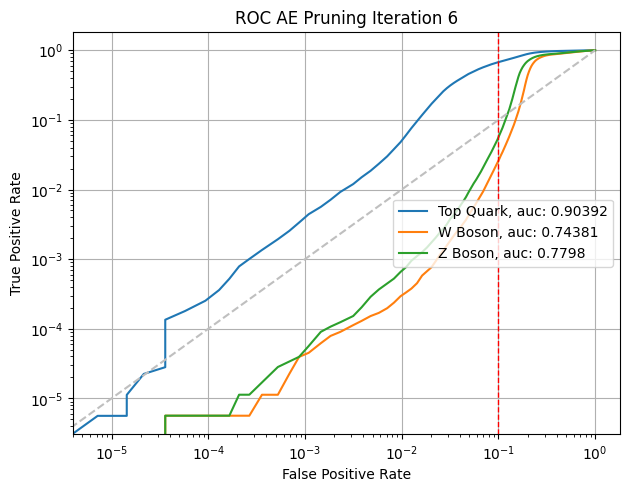

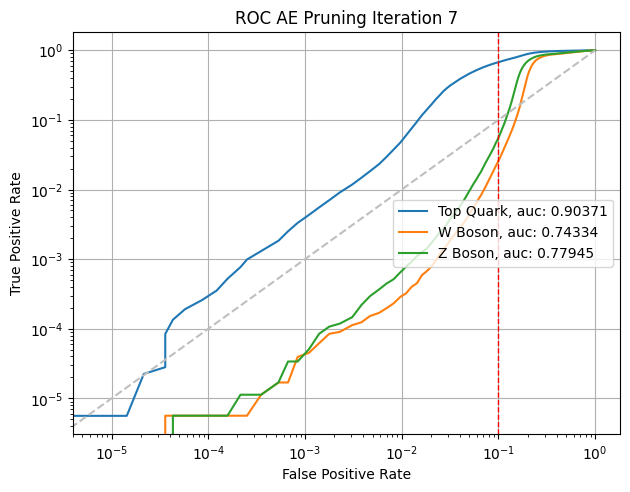

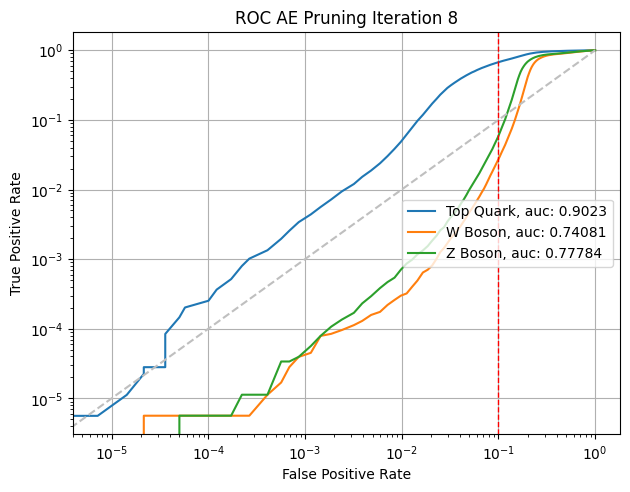

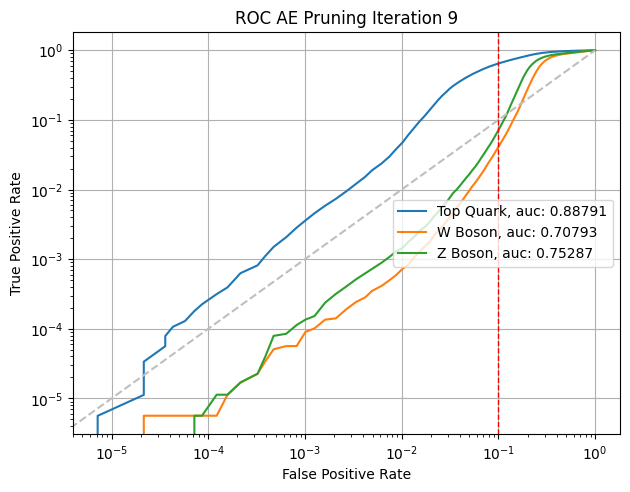

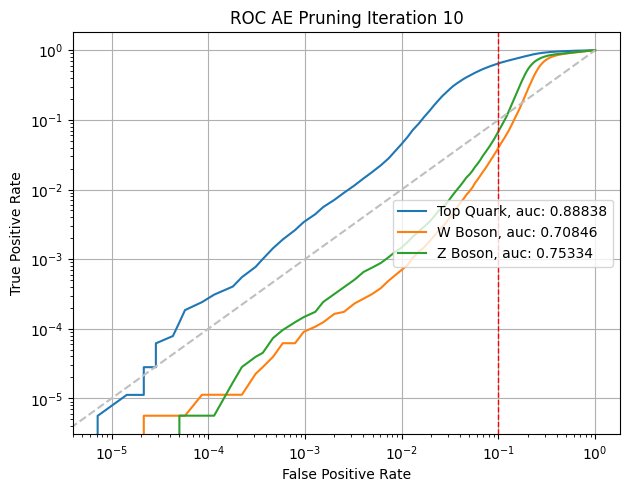

In [ ]:
# Calculate and plot Losses
fpr_losses_all, tpr_losses_all = calc_and_plot_losses(background_losses_all, signal_losses_all, signal_labels, num_thresholds=1000, plot=True)

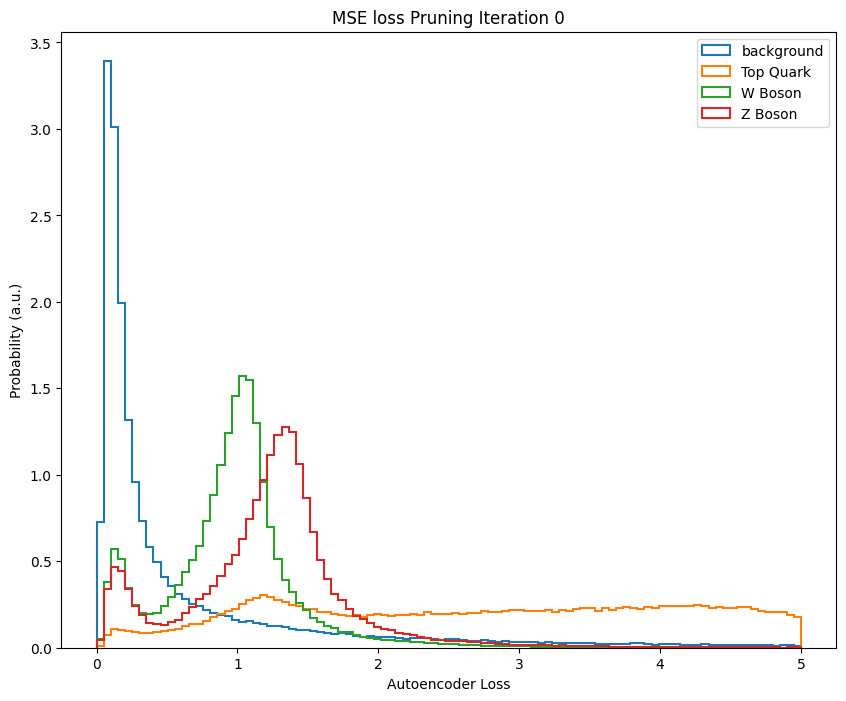

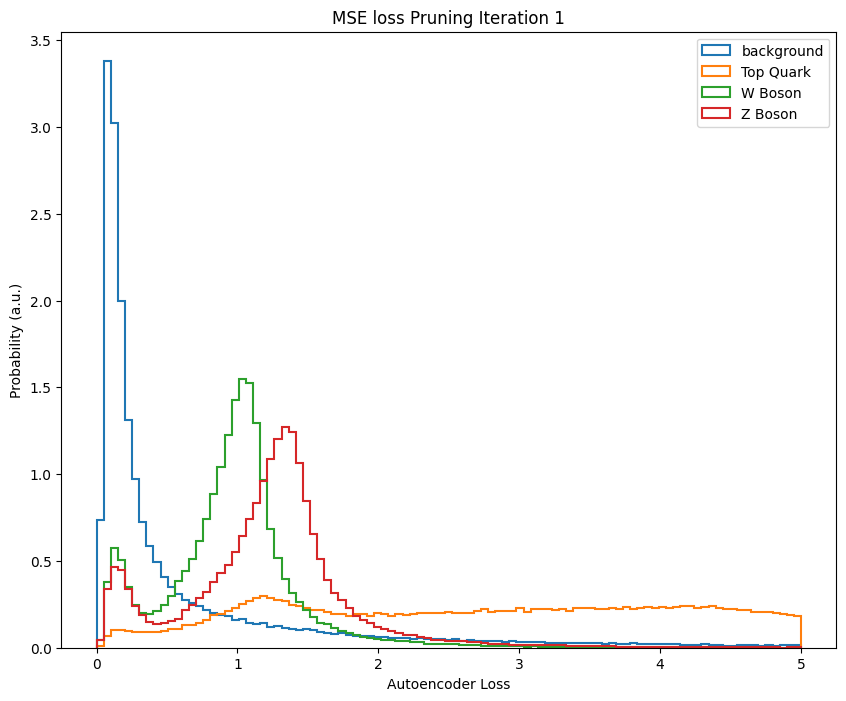

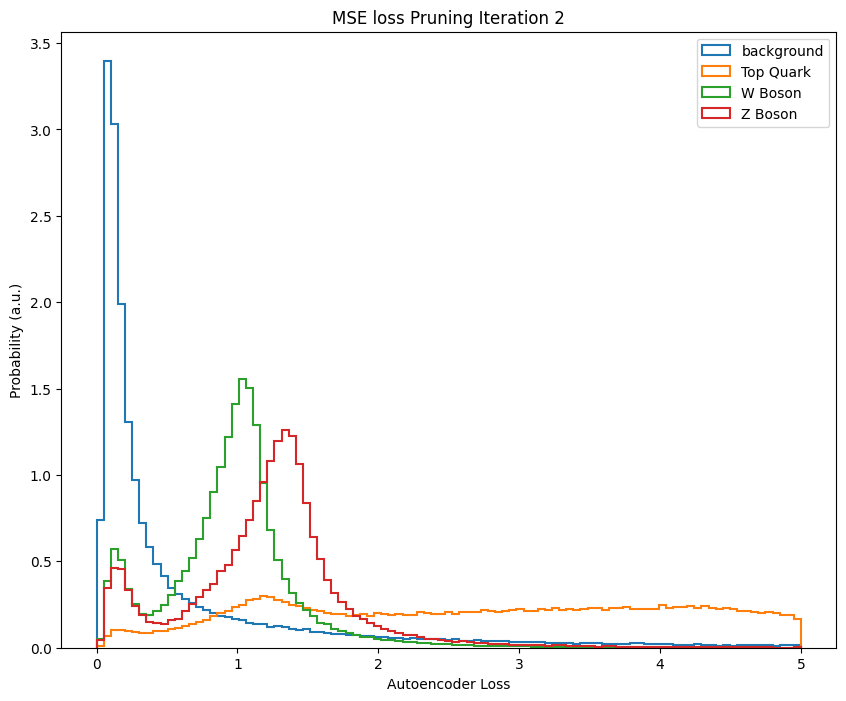

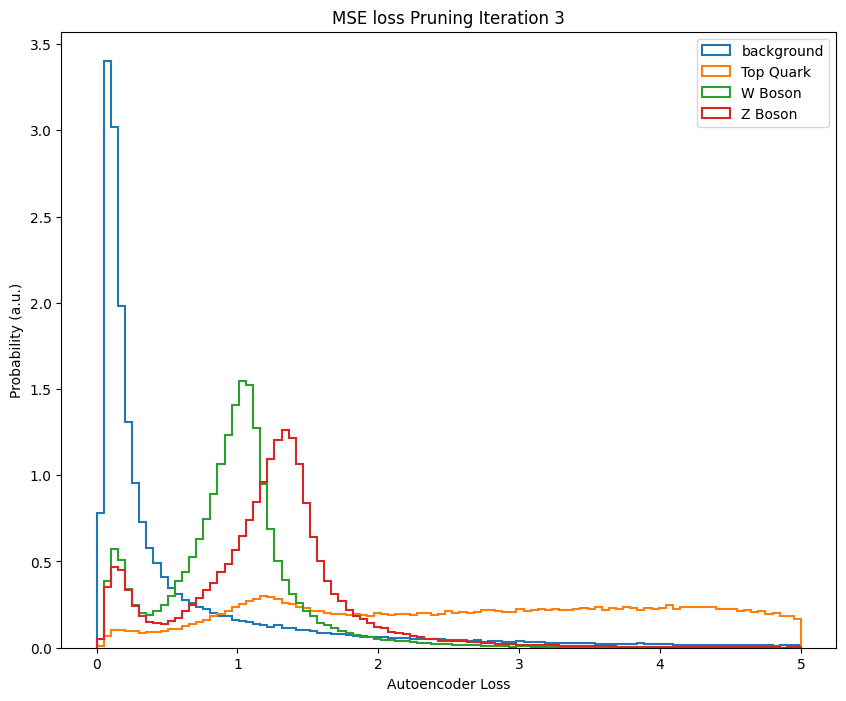

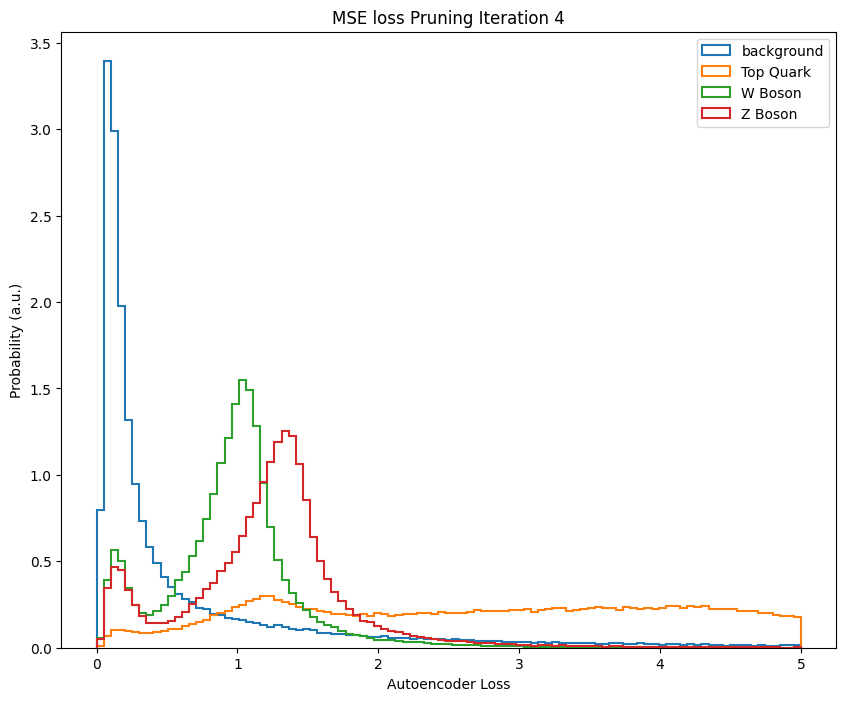

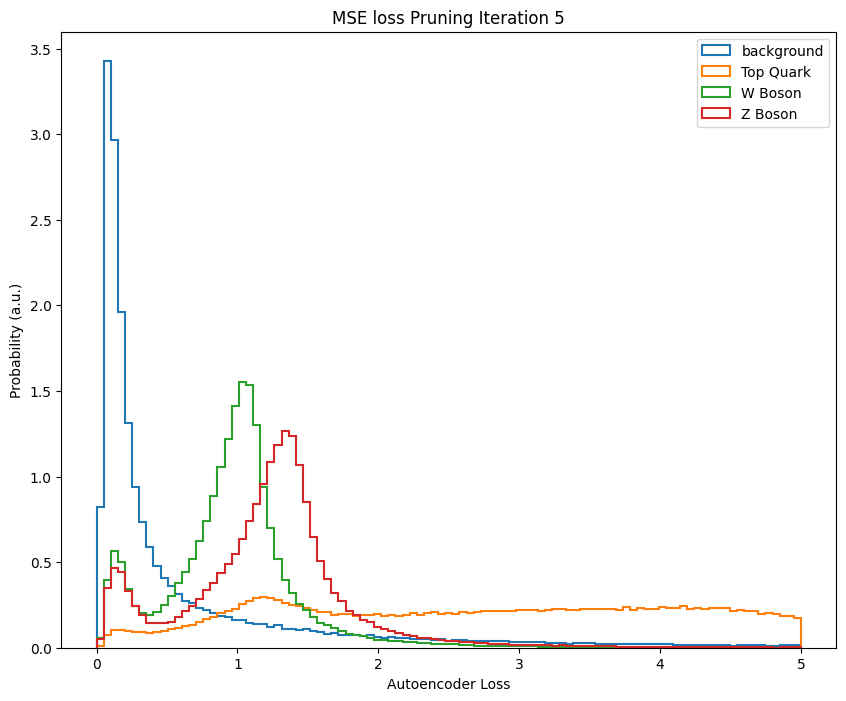

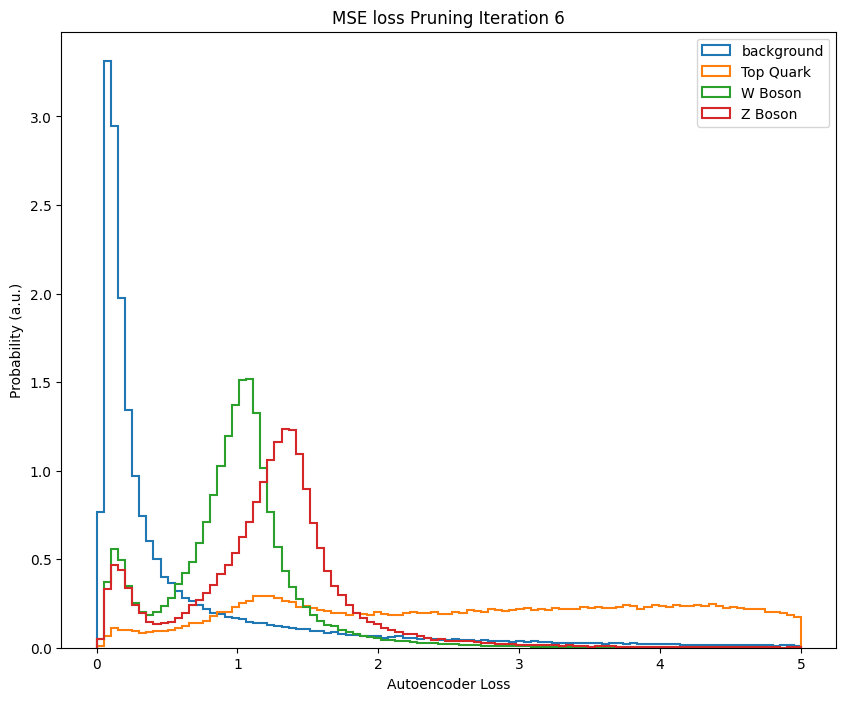

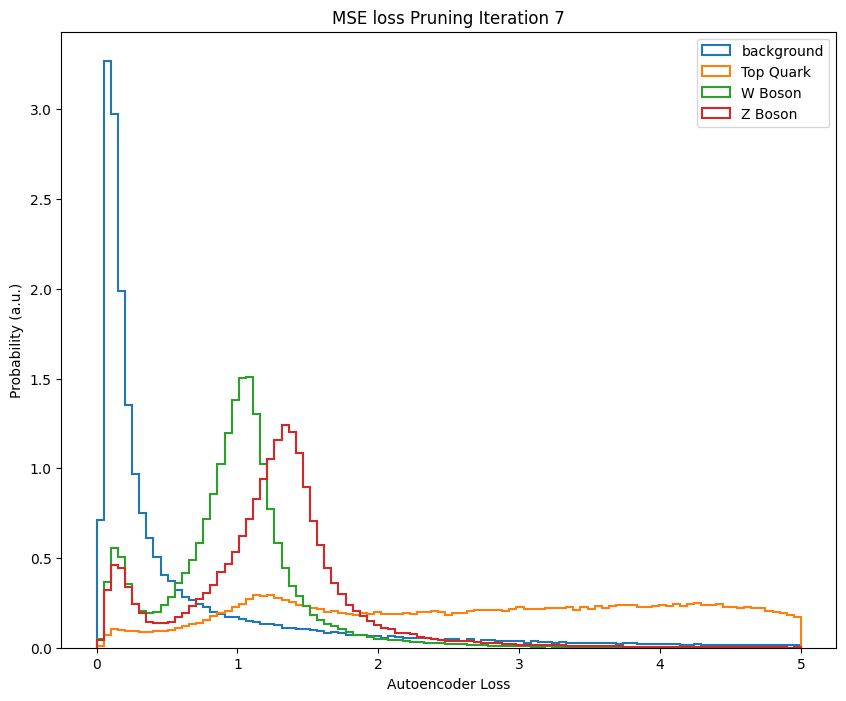

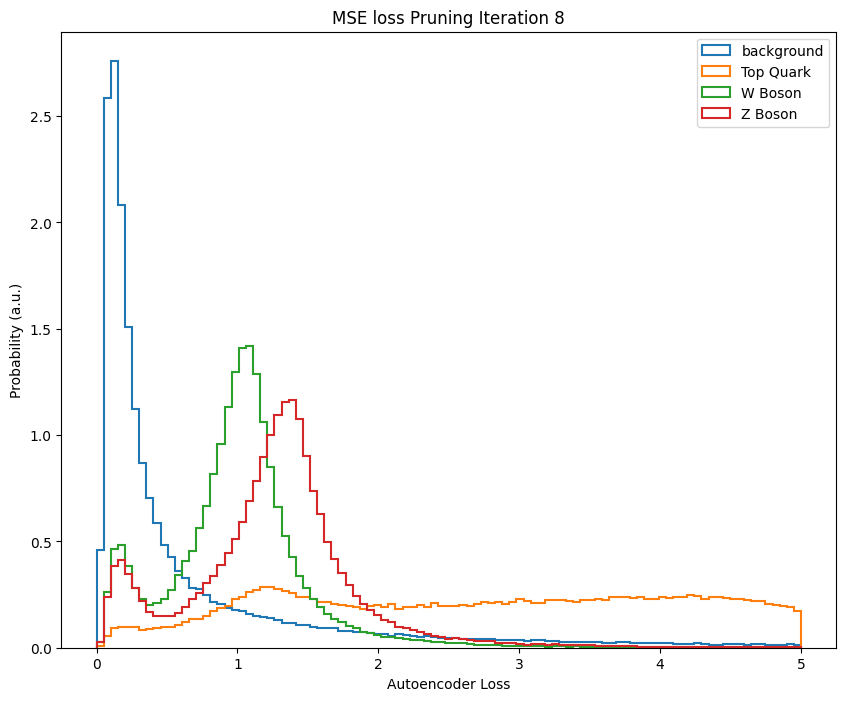

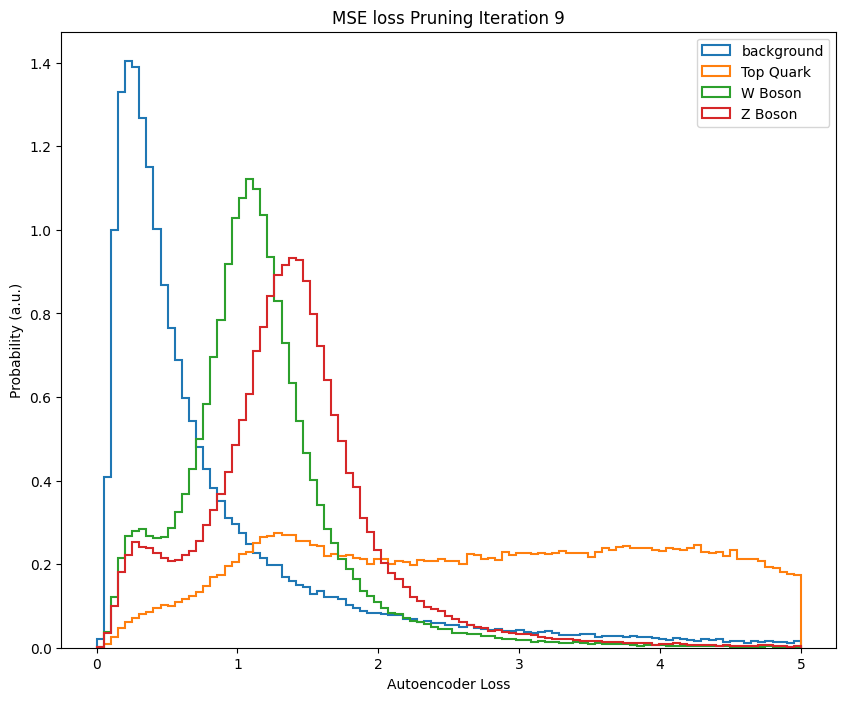

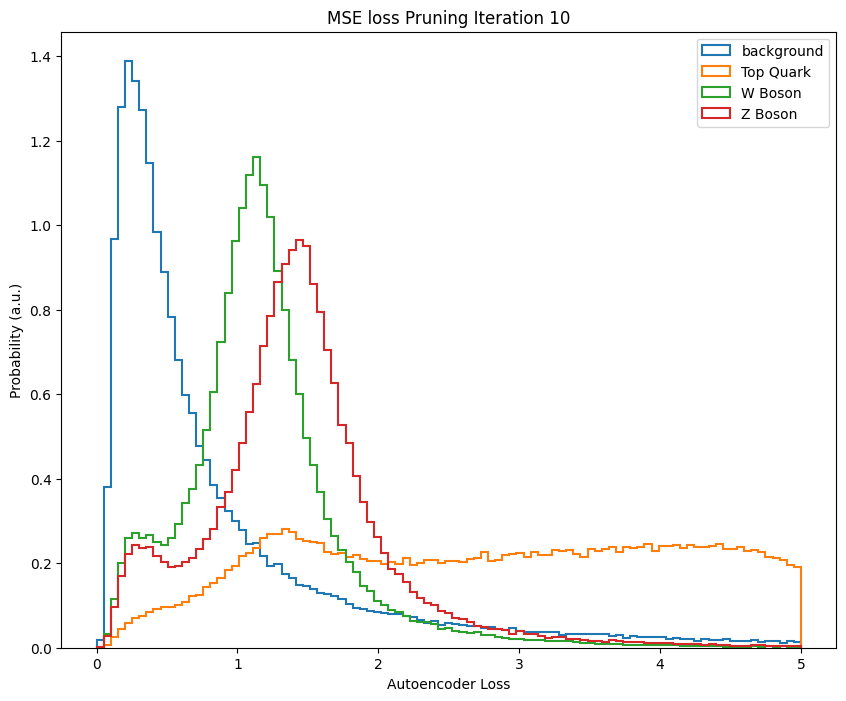

In [ ]:
# Plot histogram of losses
losses, labels = prune_plot_histogram(background_losses_all, signal_losses_all, signal_labels, bin_size = np.linspace(0,5,100), plot=True)

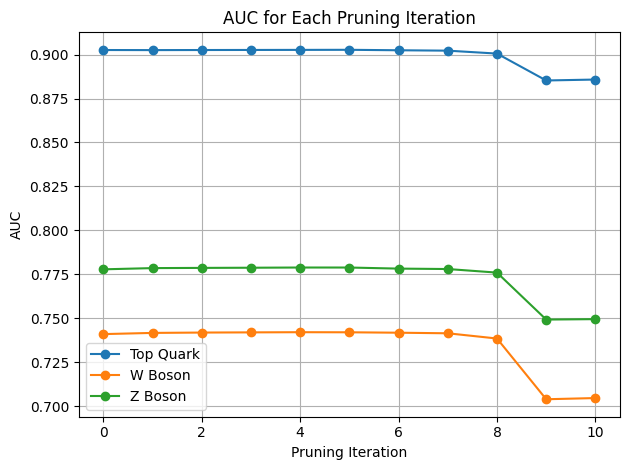

In [ ]:
plot_AUCs_for_pruning_iters(background_losses_all, signal_losses_all, signal_labels)

In [ ]:
best_iteration = get_best_average_AUC_iteration(background_losses_all, signal_losses_all, signal_labels)

Best Pruning Iteration: 4
AUC for Top Quark: 0.9026311337290217
AUC for W Boson: 0.7421834007565498
AUC for Z Boson: 0.7789461794388226


In [ ]:
background_latent = get_latent_representations(test_dataloader, model)
t_latent = get_latent_representations(t_signal_dataloader, model)
w_latent = get_latent_representations(w_signal_dataloader, model)
z_latent = get_latent_representations(z_signal_dataloader, model)

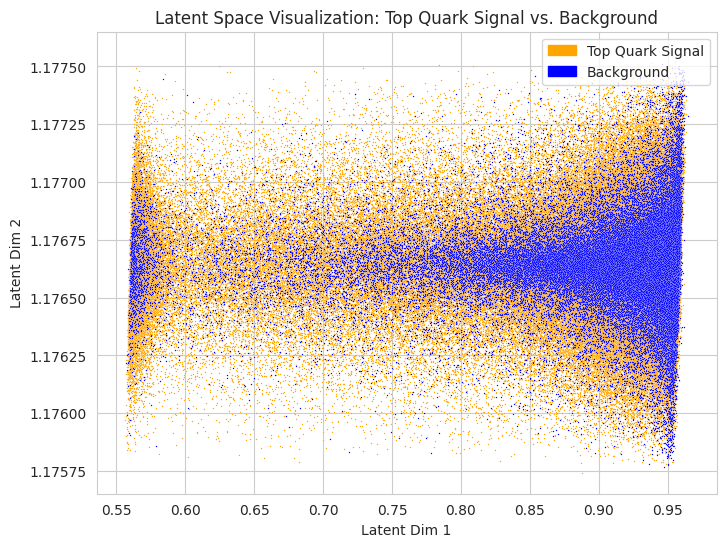

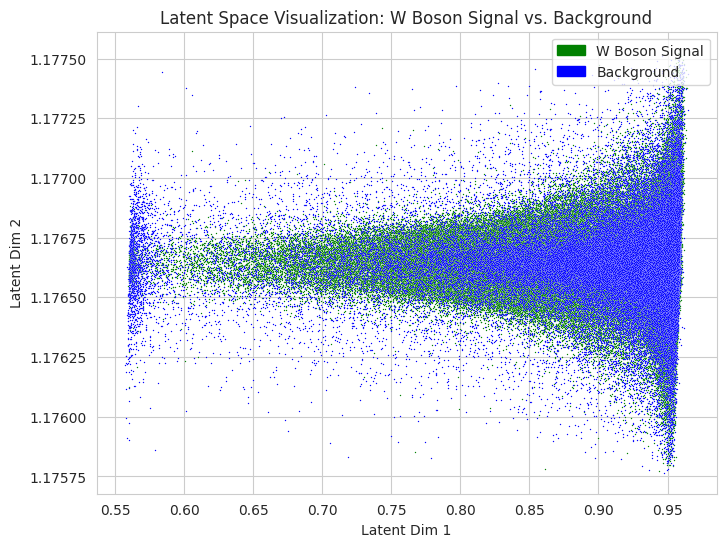

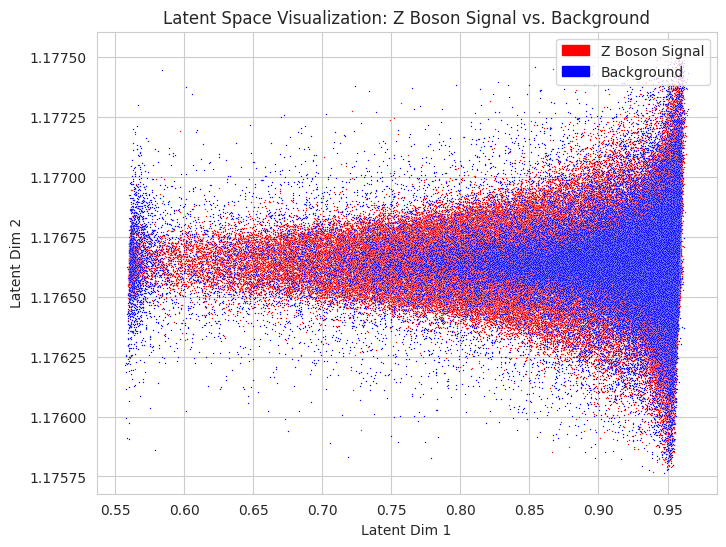

In [ ]:
# keep in mind this will plot based on the final model, not the best pruning iteration, would need to update accordingly to change this

import seaborn as sns
import matplotlib.patches as mpatches

# Set a style
sns.set_style("whitegrid")

# Function to plot background vs. one type of signal
def plot_background_vs_signal(background_latent, signal_latent, signal_label, signal_color):
    plt.figure(figsize=(8, 6))

    # Plot signal latent space without legend
    sns.scatterplot(x=signal_latent[:, 0], y=signal_latent[:, 1], color=signal_color, alpha=1, s=1)

    # Plot background latent space without legend
    sns.scatterplot(x=background_latent[:, 0], y=background_latent[:, 1], color='blue', alpha=1, s=1)

    # Manually define legend handles
    signal_patch = mpatches.Patch(color=signal_color, label=signal_label)
    background_patch = mpatches.Patch(color='blue', label='Background')

    plt.legend(handles=[signal_patch, background_patch], loc='upper right')
    plt.xlabel('Latent Dim 1')
    plt.ylabel('Latent Dim 2')
    plt.title(f"Latent Space Visualization: {signal_label} vs. Background")
    plt.show()

# Create individual plots for each signal
plot_background_vs_signal(background_latent, t_latent, 'Top Quark Signal', 'orange')
plot_background_vs_signal(background_latent, w_latent, 'W Boson Signal', 'green')
plot_background_vs_signal(background_latent, z_latent, 'Z Boson Signal', 'red')

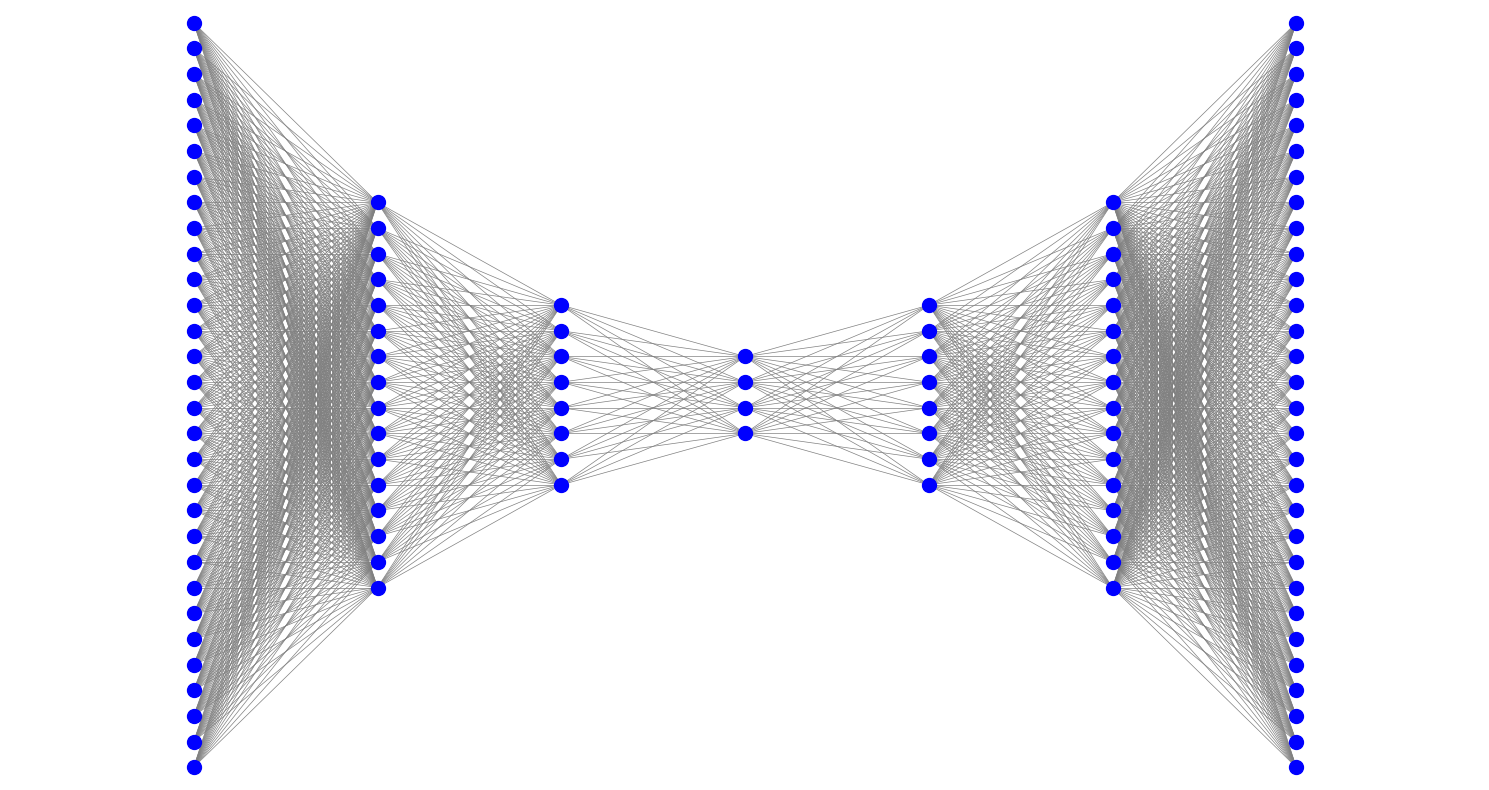

In [ ]:
def plot_specifically_pruned_neural_net(layer_sizes, sparsity_levels):
    fig, ax = plt.subplots(figsize=(15, 8))

    n_layers = len(layer_sizes)
    max_size = max(layer_sizes)
    half_max_size = max_size / 2
    layer_spacing = 10.0  # This determines the horizontal space between layers

    # Define layer positions
    layer_pos = list(np.arange(0, n_layers * layer_spacing, layer_spacing))

    for n in range(n_layers - 1):  # We will only have n-1 layers of connections
        neuron_pos = np.linspace(half_max_size - layer_sizes[n]/2, half_max_size + layer_sizes[n]/2 - 1, layer_sizes[n])
        next_neuron_pos = np.linspace(half_max_size - layer_sizes[n+1]/2, half_max_size + layer_sizes[n+1]/2 - 1, layer_sizes[n+1])

        all_connections = [(start, end) for start in neuron_pos for end in next_neuron_pos]
        pruned_connections = np.random.choice(len(all_connections), int((1-sparsity_levels[n]) * len(all_connections)), replace=False)

        for idx in pruned_connections:
            start, end = all_connections[idx]
            line = [(layer_pos[n], start), (layer_pos[n+1], end)]
            ax.add_line(plt.Line2D(*zip(*line), c='gray', lw=0.5, zorder=1))

    for n, layer_size in enumerate(layer_sizes):
        neuron_pos = np.linspace(half_max_size - layer_sizes[n]/2, half_max_size + layer_sizes[n]/2 - 1, layer_sizes[n])
        ax.scatter([layer_pos[n]] * layer_size, neuron_pos, s=100, c='blue', zorder=4)

    ax.set_aspect('auto')
    ax.set_xlim(-layer_spacing, (n_layers-1) * layer_spacing + layer_spacing)
    ax.set_ylim(-0.5, max_size - 0.5)
    ax.axis('off')

    #plt.title('Specifically Pruned Autoencoder Architecture')
    plt.tight_layout()
    plt.show()

# Assuming you've computed your sparsity levels
# layerwise_sparsity = [0.76, 0.56, 0.22, 0.31, 0.45, 0.73]  # Just a sample, replace with your actual values
layerwise_sparsity = [0, 0, 0, 0, 0, 0]

# Padding the sparsity levels to match the number of layer-to-layer connections
layer_sizes = [30, 16, 8, 4, 8, 16, 30]
sparsity_levels = layerwise_sparsity + [0] * (len(layer_sizes) - 1 - len(layerwise_sparsity))

plot_specifically_pruned_neural_net(layer_sizes, sparsity_levels)
